# Conversion of Dataset and Wikidata to a Information Extraction Dataset

## Download the KG

- https://github.com/the-qa-company/qEndpoint/blob/master/scripts/loadData.sh

- wikidata_truthy - Wikidata Truthy statements (need at least 6G of main memory and 60G of harddrive )
```
wget --progress=bar:force:noscroll -c --retry-connrefused --tries 0 --timeout 10 -O wikidata_truthy.hdt "https://qanswer-svc4.univ-st-etienne.fr/wikidata_truthy.hdt"
wget --progress=bar:force:noscroll -c --retry-connrefused --tries 0 --timeout 10 -O wikidata_truthy.hdt.index.v1-1 "https://qanswer-svc4.univ-st-etienne.fr/wikidata_truthy.hdt.index.v1-1"
```

- wikidata_all - Wikidata-all statements (need at least 10G of main memory and 325 GB of harddrive (first 195 GB + second 130 GB) - download takes 52 min for first one and 30 min for second one)

```
wget --progress=bar:force:noscroll -c --retry-connrefused --tries 0 --timeout 10 -O wikidata_all.hdt "https://qanswer-svc4.univ-st-etienne.fr/wikidata_all.hdt"
wget --progress=bar:force:noscroll -c --retry-connrefused --tries 0 --timeout 10 -O wikidata_all.hdt.index.v1-1 "https://qanswer-svc4.univ-st-etienne.fr/wikidata_all.hdt.index.v1-1"
```

In [ ]:
!cp /ceph/shertlin/wikidata/wikidata_all_new.hdt /dev/shm/wikidata_all_new.hdt
!cp /ceph/shertlin/wikidata/wikidata_all_new.hdt.index.v1-1 /dev/shm/wikidata_all_new.hdt.index.v1-1

In [ ]:
# install packages
%conda install -c pytorch -c nvidia -c conda-forge faiss-gpu=1.11.0
%pip install rdflib-hdt==3.1 tqdm==4.67.1 networkx==3.4.2 datasets==3.5.0 sentence-transformers==4.0.2 pandas==2.2.3 scikit-learn==1.6.1 matplotlib==3.10.1 notebook==7.4.2 

In [2]:
# All imports

from rdflib_hdt import HDTStore
from rdflib import Graph, URIRef, RDF, RDFS, OWL, SKOS, Literal
from tqdm import tqdm
from datetime import datetime
import networkx as nx
import re
from datasets import load_dataset
from collections import defaultdict, Counter, deque
import pandas as pd
import os
import csv
from sentence_transformers import SentenceTransformer
import pickle
from sklearn.model_selection import train_test_split
import json
import faiss
import base64
import hashlib
import numpy as np

/work/shertlin/miniconda3/envs/wikitwo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wikidata_wd = "http://www.wikidata.org/entity/"
wikidata_wdt = "http://www.wikidata.org/prop/direct/" # property direct

wikidata_wdt_instance_of = URIRef(wikidata_wdt + "P31")
wikidata_wdt_subclass_of = URIRef(wikidata_wdt + "P279")
wikidata_wdt_equivalent_class = URIRef(wikidata_wdt + "P1709")
wikidata_wdt_subproperty_of = URIRef(wikidata_wdt + "P1647")
wikidata_wdt_subproperty_of_external = URIRef(wikidata_wdt + "P2236")
wikidata_wdt_equivalent_property = URIRef(wikidata_wdt + "P1628")
wikidata_wdt_inverse_Of = URIRef(wikidata_wdt + "P1696")


## Process the KG

In [3]:
# https://github.com/RDFLib/rdflib-hdt
# Load an HDT file. Missing indexes are generated automatically
# You can provide the index file by putting it in the same directory as the HDT file.

#store = HDTStore("/data/wikidata_truthy.hdt")
#store = HDTStore("./wikidata_truthy.hdt")
#store = HDTStore("./wikidata_all.hdt")

#store = HDTStore("./wikidata_all_new.hdt")
store = HDTStore("/dev/shm/wikidata_all_new.hdt")


# Display some metadata about the HDT document itself
print(f"Number of RDF triples: {len(store)}")
print(f"Number of subjects: {store.nb_subjects}")
print(f"Number of predicates: {store.nb_predicates}")
print(f"Number of objects: {store.nb_objects}")

# Create an RDFlib Graph with the HDT document as a backend
graph = Graph(store=store)

Number of RDF triples: 2655002426
Number of subjects: 2080357704
Number of predicates: 55706
Number of objects: 3696990939


### Select Appearing Classes and Instances in the KG
According to [wikiproject page](https://www.wikidata.org/wiki/Wikidata:WikiProject_Ontology/Classes): 

1. We will define a class-item is any item used as value in a instance of (P31) statement or with a subclass of (P279) statement (subclass) or used as value in a subclass of (P279) statement (superclass).
1. By definition an instance-item in Wikidata is any item with a instance of (P31) statement.

In [4]:
all_classes = set()
all_instances = set()

#  class-item is any item used as value in a instance of (P31) statement
for i, (s, p, o) in enumerate(graph.triples((None, wikidata_wdt_instance_of, None))):
    all_instances.add(s)
    all_classes.add(o)
    if i % 1000000 == 0:
        print(f"{datetime.now().time()} - iterate over 'instance of' statements: {i}")
# ~ 10 min - 20 min

20:45:15.846775 - iterate over 'instance of' statements: 0
20:45:19.906055 - iterate over 'instance of' statements: 1000000
20:45:23.577003 - iterate over 'instance of' statements: 2000000
20:45:27.505725 - iterate over 'instance of' statements: 3000000
20:45:31.128955 - iterate over 'instance of' statements: 4000000
20:45:34.879108 - iterate over 'instance of' statements: 5000000
20:45:38.789200 - iterate over 'instance of' statements: 6000000
20:45:41.929194 - iterate over 'instance of' statements: 7000000
20:45:45.864210 - iterate over 'instance of' statements: 8000000
20:45:49.027839 - iterate over 'instance of' statements: 9000000
20:45:53.107868 - iterate over 'instance of' statements: 10000000
20:45:56.440235 - iterate over 'instance of' statements: 11000000
20:45:59.573218 - iterate over 'instance of' statements: 12000000
20:46:03.944558 - iterate over 'instance of' statements: 13000000
20:46:07.340922 - iterate over 'instance of' statements: 14000000
20:46:10.524144 - iterate 

In [5]:
# class-item is any item used as value or object in a subclass of (P279) statement
subclass_graph = nx.DiGraph()
for i, (s, p, o) in enumerate(graph.triples((None, wikidata_wdt_subclass_of, None))):
    all_classes.add(s)
    all_classes.add(o)
    subclass_graph.add_edge(s, o)
    if i % 1000000 == 0:
        print(f"{datetime.now().time()} - iterate over 'subclass of' statements: {i} / ~ 4000000")
print(f"all classes: {len(all_classes)}")
print(f"all instances: {len(all_instances)}")
# ~ 6 min

21:00:28.478920 - iterate over 'subclass of' statements: 0 / ~ 4000000
21:00:34.022039 - iterate over 'subclass of' statements: 1000000 / ~ 4000000
21:00:38.953094 - iterate over 'subclass of' statements: 2000000 / ~ 4000000
21:01:01.490684 - iterate over 'subclass of' statements: 3000000 / ~ 4000000
21:01:07.062089 - iterate over 'subclass of' statements: 4000000 / ~ 4000000
all classes: 4188206
all instances: 106772431


In [6]:
# filter out classes that can be instances (e.g. classes that do not have any instances and are no superclass of other classes)
classes_that_are_instances = set()

class_leaves = [node for node in subclass_graph.nodes if subclass_graph.in_degree(node) == 0]
print(f"class leaves (no ingoing subclass properties): {len(class_leaves)}")
for clazz in class_leaves:
    has_instances = False
    for s,p,o in graph.triples((None, wikidata_wdt_instance_of, clazz)):
        has_instances = True
        break
    if not has_instances:
        classes_that_are_instances.add(clazz)
print(f"classes that are instances: {len(classes_that_are_instances)}")
real_classes = all_classes - classes_that_are_instances
print(f"real classes: {len(real_classes)}")

for class_to_be_instance in classes_that_are_instances:
    subclass_graph.remove_node(class_to_be_instance)

#class leaves (no ingoing subclass properties): 3917071
#classes that are instances: 3863800
#real classes: 313384

class leaves (no ingoing subclass properties): 3917071
classes that are instances: 3863800
real classes: 324406


In [ ]:
# fix all cycles
while True:
    try:
        cycle = nx.find_cycle(subclass_graph, orientation="original")
        print(cycle)
        subclass_graph.remove_edge(cycle[0][0], cycle[0][1])
    except nx.exception.NetworkXNoCycle:
        break
# ~ 65 min

### Select Appearing Properties in the KG

In [ ]:
property_type = URIRef("http://wikiba.se/ontology#propertyType")
external_id = URIRef("http://wikiba.se/ontology#ExternalId")
wikidata_property = URIRef("http://wikiba.se/ontology#Property")

all_properties = set()
for s, p, o in graph.triples((None, property_type, None)):
    all_properties.add(s)
for s, p, o in graph.triples((None, RDF.type, wikidata_property)):
    all_properties.add(s)

subproperty_graph = nx.DiGraph()
for i, (s, p, o) in enumerate(graph.triples((None, wikidata_wdt_subproperty_of, None))):
    subproperty_graph.add_edge(s, o)
for i, (s, p, o) in enumerate(graph.triples((None, wikidata_wdt_subproperty_of_external, None))):
    subproperty_graph.add_edge(s, o)


# search for properties that are identifiers:
# https://www.wikidata.org/wiki/Wikidata:Identifiers
# Wikidata property with datatype external identifier: ?p wikibase:propertyType wikibase:ExternalId
identifier_properties = set()

for property in all_properties:
    if (property, property_type, external_id) in graph:
        identifier_properties.add(property)
non_identifier_properties = all_properties - identifier_properties

non_identifier_properties_direct = set()
for p in non_identifier_properties:
    for s, p, o in graph.triples((p, URIRef("http://wikiba.se/ontology#directClaim"), None)):
        non_identifier_properties_direct.add(o)

print(f"Number of non-identifer properties: {len(non_identifier_properties_direct)} (general uri props: {len(non_identifier_properties)}) out of {len(all_properties)}")

Number of non-identifer properties: 3092 (general uri props: 3092) out of 12012


In [ ]:
# fix all cycles
while True:
    try:
        cycle = nx.find_cycle(subproperty_graph, orientation="original")
        print(cycle)
        subproperty_graph.remove_edge(cycle[0][0], cycle[0][1])
    except nx.exception.NetworkXNoCycle:
        break
# ~

In [18]:
# remove classes from instances
all_instances = all_instances - real_classes
all_instances = all_instances - classes_that_are_instances

#### Check and Write/Load Cache

In [5]:
# all should be 0

#instances with classes
print(len(all_instances.intersection(real_classes)))
print(len(classes_that_are_instances.intersection(real_classes)))

# instances with properties
print(len(all_instances.intersection(non_identifier_properties_direct)))
print(len(classes_that_are_instances.intersection(non_identifier_properties_direct)))

# classes with properties
print(len(real_classes.intersection(non_identifier_properties_direct)))

#instance with instances
print(len(all_instances.intersection(classes_that_are_instances)))

0
0
0
0
0
0


In [4]:
kg_cache_file = "kg_info.pickle"
if os.path.exists(kg_cache_file):
    print(f"Load kg cache file: {kg_cache_file}")
    with open(kg_cache_file, 'rb') as f:
        object_to_load = pickle.load(f)
        non_identifier_properties_direct = object_to_load["non_identifier_properties_direct"]
        classes_that_are_instances = object_to_load["classes_that_are_instances"]
        real_classes = object_to_load["real_classes"]
        all_instances = object_to_load["all_instances"]
        subclass_graph = object_to_load["subclass_graph"]
        subproperty_graph = object_to_load["subproperty_graph"]
else:
    # store kg cache
    print(f"Store kg cache file: {kg_cache_file}")
    with open(kg_cache_file, 'wb') as f:
        object_to_store = {
            "non_identifier_properties_direct": non_identifier_properties_direct,
            "classes_that_are_instances": classes_that_are_instances,
            "real_classes": real_classes,
            "all_instances": all_instances,
            "subclass_graph": subclass_graph,
            "subproperty_graph": subproperty_graph
        }
        pickle.dump(object_to_store, f)
# ~ 4 min 20 sec

Load kg cache file: kg_info.pickle


## Download and Process the Dataset
In the following we process the dataset with the information which entities are classes, properties and instances.

And we remove the triples that are not valid RDFS/OWL (DL) statements (according to our definition).

In [7]:
# _pc datasets are post processed - see https://huggingface.co/datasets/martinjosifoski/SynthIE
raw_train_dataset = load_dataset("martinjosifoski/SynthIE", "synthie_code", split="train")
raw_val_dataset = load_dataset("martinjosifoski/SynthIE", "synthie_text", split="validation")
raw_test_dataset = load_dataset("martinjosifoski/SynthIE", "synthie_text", split="test")

def process_dataset(dataset):
    """
    Process the dataset to extract triples and text.
    Returns a list of tuples, each containing the text and a list of triples.
    """
    uri_regex = re.compile(r"'uri': '(\w+)'")
    processed_dataset = []
    for row in dataset:    
        raw_triples = []
        for triple in row['triplets']:
            match_subj = uri_regex.search(triple['subject'])
            match_pred = uri_regex.search(triple['predicate'])
            match_obj = uri_regex.search(triple['object'])

            if not match_subj or not match_pred or not match_obj:
                print('Error: Could not find URI in triple:', triple)
                continue
            raw_triples.append((URIRef(wikidata_wd + match_subj.group(1)), URIRef(wikidata_wdt + match_pred.group(1)), URIRef(wikidata_wd + match_obj.group(1))))
        processed_dataset.append((row['text'], raw_triples))
    return processed_dataset


raw_train_dataset = process_dataset(raw_train_dataset)
raw_val_dataset = process_dataset(raw_val_dataset)
raw_test_dataset = process_dataset(raw_test_dataset)

# ~ 2 min 55 sec

In [10]:
# analyze the dataset

def get_type_of_element(element):
    if element in real_classes:
        return "C" # class
    if element == wikidata_wdt_instance_of:
        return "A" # A = rdf:type
    if element == wikidata_wdt_subclass_of:
        return "subclass"
    if element == wikidata_wdt_equivalent_class:
        return "equivalentClass"
    if element == wikidata_wdt_subproperty_of or element == wikidata_wdt_subproperty_of_external:
        return "subproperty"
    if element == wikidata_wdt_equivalent_property:
        return "equivalentProp"
    if element == wikidata_wdt_inverse_Of:
        return "inverseOf"
    if element in non_identifier_properties_direct:
        return "P" # property (any property except instance of)    
    if element in all_instances or element in classes_that_are_instances:
        return "I" # instance
    return "U" # unknown

def analyze_dataset(dataset):
    """
    Analyze the dataset to count the number of triples of each type.
    """
    types_of_triples = Counter()
    for text, triples in dataset:
        for triple in triples:
            types_of_triples[get_type_of_element(triple[0]) + '_' + get_type_of_element(triple[1])+ '_' + get_type_of_element(triple[2])] += 1
    return types_of_triples


display(analyze_dataset(raw_train_dataset))
display(analyze_dataset(raw_val_dataset))
display(analyze_dataset(raw_test_dataset))
#examples['C_A_C'][0] # Langbeinite.... It is an instance of the Crystal system, which is a subclass of Structure.  <- instance and subclass of 
# ~ 25 seconds

Counter({'I_P_I': 3386423,
         'I_P_C': 1469329,
         'I_A_C': 474694,
         'C_P_C': 304017,
         'C_P_I': 260389,
         'C_subclass_C': 76971,
         'I_subclass_C': 32882,
         'C_A_C': 23658,
         'U_P_I': 11371,
         'U_P_C': 7864,
         'I_P_U': 3956,
         'C_P_U': 1557,
         'U_A_C': 1306,
         'I_A_I': 364,
         'U_subclass_C': 255,
         'I_A_U': 244,
         'C_subclass_I': 193,
         'C_subclass_U': 141,
         'U_P_U': 115,
         'I_subclass_I': 84,
         'C_A_U': 36,
         'C_A_I': 30,
         'I_subclass_U': 24,
         'U_A_U': 5,
         'U_A_I': 3})

Counter({'I_P_I': 19276,
         'I_P_C': 8050,
         'I_A_C': 2378,
         'C_P_C': 1929,
         'C_P_I': 1647,
         'C_subclass_C': 495,
         'I_subclass_C': 197,
         'C_A_C': 152,
         'U_P_I': 44,
         'U_P_C': 37,
         'I_P_U': 27,
         'U_A_C': 10,
         'C_P_U': 7,
         'U_subclass_C': 5,
         'I_A_I': 5,
         'I_subclass_I': 1,
         'I_A_U': 1,
         'C_A_U': 1})

Counter({'I_P_I': 97246,
         'I_P_C': 40784,
         'I_A_C': 12136,
         'C_P_C': 9860,
         'C_P_I': 7901,
         'C_subclass_C': 2371,
         'I_subclass_C': 1115,
         'C_A_C': 870,
         'U_P_I': 287,
         'U_P_C': 193,
         'I_P_U': 111,
         'C_P_U': 49,
         'U_A_C': 35,
         'I_A_I': 8,
         'U_subclass_C': 6,
         'I_subclass_I': 4,
         'C_subclass_I': 4,
         'C_subclass_U': 3,
         'I_A_U': 3,
         'U_P_U': 2,
         'C_A_U': 2,
         'C_A_I': 1})

In [12]:
def filter_correct_dl_triples(dataset):
    filtered_dataset = []
    for text, triples in dataset:
        wrong_triple = False
        for s, p, o in triples:
            if p == wikidata_wdt_instance_of:
                if s not in all_instances and not s in classes_that_are_instances:
                    wrong_triple = True
                    break
                if o not in real_classes:
                    wrong_triple = True
                    break
            elif p == wikidata_wdt_subclass_of or p == wikidata_wdt_equivalent_class: # subclass of or equivalent class
                if s not in real_classes or o not in real_classes:
                    wrong_triple = True
                    break
            elif p == wikidata_wdt_subproperty_of or p == wikidata_wdt_subproperty_of_external or \
                    p == wikidata_wdt_equivalent_property or p == wikidata_wdt_inverse_Of: # subproperty, external subproperty, equivalent, inverse prop, 
                if s not in non_identifier_properties_direct or o not in non_identifier_properties_direct:
                    wrong_triple = True
                    break
            else:
                # instance, any property, instance
                if s not in all_instances and not s in classes_that_are_instances:
                    wrong_triple = True
                    break
                if p not in non_identifier_properties_direct:
                    wrong_triple = True
                    break
                if o not in all_instances and not o in classes_that_are_instances:
                    wrong_triple = True
                    break
        if not wrong_triple:   
            filtered_dataset.append((text, triples))
    return filtered_dataset


train_dataset = filter_correct_dl_triples(raw_train_dataset)
val_dataset = filter_correct_dl_triples(raw_val_dataset)
test_dataset = filter_correct_dl_triples(raw_test_dataset)

print(f"Train dataset size: {len(train_dataset)} / {len(raw_train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)} / {len(raw_val_dataset)}")
print(f"Test dataset size: {len(test_dataset)} / {len(raw_test_dataset)}")

# Train dataset size: 678054 / 1815378
# Validation dataset size: 3733 / 10000
# Test dataset size: 18693 / 50286

# ~ 10 sec

Train dataset size: 678054 / 1815378
Validation dataset size: 3733 / 10000
Test dataset size: 18693 / 50286


In [13]:
display(analyze_dataset(train_dataset))
display(analyze_dataset(val_dataset))
display(analyze_dataset(test_dataset))
# ~ 7 sec

Counter({'I_P_I': 1617268, 'I_A_C': 168071, 'C_subclass_C': 5081})

Counter({'I_P_I': 9224, 'I_A_C': 894, 'C_subclass_C': 24})

Counter({'I_P_I': 46628, 'I_A_C': 4379, 'C_subclass_C': 111})

### Determine Removed Properties

We will start with properties, because there we have only a few.

In [14]:
# combine val and test to one dataset and split it afterwards again
# combined_val_test_dataset will be modified during the processing
combined_val_test_dataset = val_dataset + test_dataset 

stable_combined_val_test_dataset = val_dataset + test_dataset # this is the one that will not be modified

# validation is 20 %, test is 80 %
test_size = 0.8
print(f"Combined validation and test dataset size: {len(combined_val_test_dataset)}")
# need to rerun this cell because combined_val_test_dataset is modified

Combined validation and test dataset size: 22426


In [17]:
def count_properties(dataset):
    property_counter = Counter()
    for text, triples in dataset:
        for s, p, o in triples:
            property_counter[p] += 1    
    return property_counter

train_property_counter = count_properties(train_dataset)
val_test_property_counter = count_properties(combined_val_test_dataset)

sum_counter = train_property_counter + val_test_property_counter
print(f"Train dataset property counter: {len(train_property_counter)}")
print(f"Combined validation and test dataset property counter: {len(val_test_property_counter)}")
print(f"Sum property counter: {len(sum_counter)}")
# ~6 sec

Train dataset property counter: 827
Combined validation and test dataset property counter: 764
Sum property counter: 827


In [64]:
# debug
df_train = pd.DataFrame(train_property_counter.items(), columns=['property', 'count_train'])
df_val_test = pd.DataFrame(val_test_property_counter.items(), columns=['property', 'count_val_test'])
df_sum = pd.DataFrame(sum_counter.items(), columns=['property', 'sum'])

df_combined = pd.merge(df_train, df_val_test, on='property', how='outer')
df_combined = pd.merge(df_combined, df_sum, on='property', how='outer')

#sort the dataframe by the sum of the counts
df_combined = df_combined.sort_values(by='sum')
df_combined.to_csv("wikidata_properties.csv", index=False)
# max 1 sec

In [21]:
number_of_properties_to_remove_in_train = int(len(train_property_counter) * 0.05)
number_of_properties_to_remove_in_val_test = int(len(val_test_property_counter) * 0.05)
print(number_of_properties_to_remove_in_train)
print(number_of_properties_to_remove_in_val_test)

41
38


In [22]:
removed_properties_in_train = set()
removed_properties_in_val_test = set()

for p, count in sum_counter.most_common()[::-1]:
    if p in val_test_property_counter:
        removed_properties_in_val_test.add(p)
    if len(removed_properties_in_val_test) >= number_of_properties_to_remove_in_val_test:
        break
for p in removed_properties_in_val_test:
    del sum_counter[p]

for p, count in sum_counter.most_common()[::-1]:
    if p in train_property_counter:
        removed_properties_in_train.add(p)
    if len(removed_properties_in_train) >= number_of_properties_to_remove_in_train:
        break

removed_properties_in_val, removed_properties_in_test = train_test_split(sorted(list(removed_properties_in_val_test)), test_size=test_size, random_state=42)
removed_properties_in_val = set(removed_properties_in_val) # make it a set again
removed_properties_in_test = set(removed_properties_in_test) # make it a set again

print(f"removed properties in train: {len(removed_properties_in_train)} {list(removed_properties_in_train)[:5]}")
print(f"removed properties in val: {len(removed_properties_in_val)} {list(removed_properties_in_val)[:5]}")
print(f"removed properties in test: {len(removed_properties_in_test)} {list(removed_properties_in_test)[:5]}")
# max 1 sec


removed properties in train: 41 [rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P636'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P588'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P4000'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1013'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P360')]
removed properties in val: 7 [rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P5166'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P7937'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1654'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P3776'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P4967')]
removed properties in test: 31 [rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P3005'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P8339'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P841'), rdflib.term.URIRef('http://www.wikidata.org/prop/direct/P1002'),

In [ ]:
# remove all examples in train/val/test where the property is used

new_val_dataset = []
new_test_dataset = []

def is_one_property_contained(set_of_properties, triples):
    for s, p, o in triples:
        if p in set_of_properties:
            return True
    return False

# remove all examples in train where the property should be created in val/test
set_removed_properties_in_val_or_test = removed_properties_in_val.union(removed_properties_in_test)
train_dataset[:] = [(text, triples) for (text, triples) in train_dataset if is_one_property_contained(set_removed_properties_in_val_or_test, triples) == False]

# split the combined val/test dataset into val and test (partially)
# add all examples where property is used in val to the new val dataset (thus it will only appear in val)
# remove those examples from the combined_val_test_dataset
def remove_examples_from_valtest_and_add_it_to_provided_dataset_for_properties(removed_ones, provided_dataset):
    for text, triples in combined_val_test_dataset:
        if is_one_property_contained(removed_ones, triples):
            provided_dataset.append((text, triples))
    combined_val_test_dataset[:] = [(text, triples) for (text, triples) in combined_val_test_dataset if is_one_property_contained(removed_ones, triples) == False] 


remove_examples_from_valtest_and_add_it_to_provided_dataset_for_properties(removed_properties_in_val, new_val_dataset)
remove_examples_from_valtest_and_add_it_to_provided_dataset_for_properties(removed_properties_in_test, new_test_dataset)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(new_val_dataset)}")
print(f"Test dataset size: {len(new_test_dataset)}")
print(f"Combined val/test dataset size: {len(combined_val_test_dataset)}")

# max 1 sec

Train dataset size: 677272
Validation dataset size: 8
Test dataset size: 56
Combined val/test dataset size: 22362


### Determine Removed Classes

In [25]:
co_occuring_classes = defaultdict(set)
def compute_co_occuring_classes(dataset):
    for text, triples in dataset:
        for s, p, o in triples:
            if s in real_classes and o in real_classes:
                co_occuring_classes[s].add(o)
                co_occuring_classes[o].add(s)
compute_co_occuring_classes(train_dataset)
compute_co_occuring_classes(stable_combined_val_test_dataset)

def count_classes(dataset):
    class_counter = Counter()
    for text, triples in dataset:
        for s, p, o in triples:
            if s in real_classes:
                class_counter[s] += 1
            if o in real_classes:
                class_counter[o] += 1
    return class_counter

train_class_counter = count_classes(train_dataset)
val_test_class_counter = count_classes(combined_val_test_dataset)
sum_class_counter = train_class_counter + val_test_class_counter

print(f"Train dataset class counter: {len(train_class_counter)}")
print(f"Combined validation and test dataset class counter: {len(val_test_class_counter)}")
print(f"Sum class counter: {len(sum_class_counter)}")
# max 4 sec


Train dataset class counter: 8621
Combined validation and test dataset class counter: 1374
Sum class counter: 8765


In [18]:
# debug
df_train = pd.DataFrame(train_class_counter.items(), columns=['class', 'count_train'])
df_val_test = pd.DataFrame(val_test_class_counter.items(), columns=['class', 'count_val_test'])
df_sum = pd.DataFrame(sum_class_counter.items(), columns=['class', 'sum'])

df_combined = pd.merge(df_train, df_val_test, on='class', how='outer')
df_combined = pd.merge(df_combined, df_sum, on='class', how='outer')

#sort the dataframe by the sum of the counts
df_combined = df_combined.sort_values(by='sum')
df_combined.to_csv("wikidata_classes.csv", index=False)
# max 1 sec

In [26]:
number_of_classes_to_remove_in_train = int(len(train_class_counter) * 0.2)
number_of_classes_to_remove_in_val_test = int(len(val_test_class_counter) * 0.2)
print(number_of_classes_to_remove_in_train)
print(number_of_classes_to_remove_in_val_test)

1724
274


In [27]:
# classes that need to be removed
removed_classes_in_train = set()
removed_classes_in_val_test = set()

modifiable_class_counter_for_val_test = dict(sum_class_counter.most_common()[::-1])
modifiable_class_counter_for_val_test = {key: value for key, value in modifiable_class_counter_for_val_test.items() if key in val_test_class_counter}
for x in tqdm(range(number_of_classes_to_remove_in_val_test)):
    chosen_class = next(iter(modifiable_class_counter_for_val_test))
    removed_classes_in_val_test.add(chosen_class)
    del modifiable_class_counter_for_val_test[chosen_class]
    for x in co_occuring_classes[chosen_class]:
        if x in modifiable_class_counter_for_val_test:
            del modifiable_class_counter_for_val_test[x]

modifiable_class_counter_for_train = dict(sum_class_counter.most_common()[::-1])
modifiable_class_counter_for_train = {key: value for key, value in modifiable_class_counter_for_train.items() \
                                      if key in train_class_counter and key not in removed_classes_in_val_test}
for x in tqdm(range(number_of_classes_to_remove_in_train)):
    chosen_class = next(iter(modifiable_class_counter_for_train))
    removed_classes_in_train.add(chosen_class)
    del modifiable_class_counter_for_train[chosen_class]
    for x in co_occuring_classes[chosen_class]:
        if x in modifiable_class_counter_for_train:
            del modifiable_class_counter_for_train[x]

removed_classes_in_val, removed_classes_in_test = train_test_split(sorted(list(removed_classes_in_val_test)), test_size=test_size, random_state=42)
removed_classes_in_val = set(removed_classes_in_val) # make it a set again
removed_classes_in_test = set(removed_classes_in_test) # make it a set again

print(f"removed classes in train: {len(removed_classes_in_train)} {list(removed_classes_in_train)[:5]}")
print(f"removed classes in val: {len(removed_classes_in_val)} {list(removed_classes_in_val)[:5]}")
print(f"removed classes in test: {len(removed_classes_in_test)} {list(removed_classes_in_test)[:5]}")
# max 1 sec

100%|██████████| 1724/1724 [00:00<00:00, 823949.42it/s]

removed classes in train: 1724 [rdflib.term.URIRef('http://www.wikidata.org/entity/Q170406'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q58702'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q2139'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q2314257'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q18185')]
removed classes in val: 54 [rdflib.term.URIRef('http://www.wikidata.org/entity/Q190107'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q1776834'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q531152'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q2707153'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q19152599')]
removed classes in test: 220 [rdflib.term.URIRef('http://www.wikidata.org/entity/Q10260870'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q1641572'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q1033904'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q82996'), rdflib.term.URIRef('http://www.wikidat

In [28]:
# remove all examples in train where the class is used

def is_one_subject_or_object_contained(set_of_entities, triples):
    for s, p, o in triples:
        if s in set_of_entities or o in set_of_entities:
            return True
    return False

# remove all examples in train where the class should be created in val/test
train_dataset[:] = [(text, triples) for (text, triples) in train_dataset if is_one_subject_or_object_contained(removed_classes_in_val_test, triples) == False]

# split the combined val/test dataset into val and test (partially)
def remove_examples_from_valtest_and_add_it_to_provided_dataset_for_entities(removed_ones, provided_dataset):
    for text, triples in combined_val_test_dataset:
        if is_one_subject_or_object_contained(removed_ones, triples):
            provided_dataset.append((text, triples))
    combined_val_test_dataset[:] = [(text, triples) for (text, triples) in combined_val_test_dataset if is_one_subject_or_object_contained(removed_ones, triples) == False] 

remove_examples_from_valtest_and_add_it_to_provided_dataset_for_entities(removed_classes_in_val, new_val_dataset)
remove_examples_from_valtest_and_add_it_to_provided_dataset_for_entities(removed_classes_in_test, new_test_dataset)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(new_val_dataset)}")
print(f"Test dataset size: {len(new_test_dataset)}")
print(f"Combined val/test dataset size: {len(combined_val_test_dataset)}")
# max 2 sec

Train dataset size: 677025
Validation dataset size: 63
Test dataset size: 266
Combined val/test dataset size: 22097


### Determine Removed Instances/Individuals

In [29]:
co_occuring_instances = defaultdict(set)
def compute_co_occuring_instances(dataset):
    for text, triples in dataset:
        for s, p, o in triples:
            if (s in all_instances or s in classes_that_are_instances) and \
                (o in all_instances or o in classes_that_are_instances):
                co_occuring_instances[s].add(o)
                co_occuring_instances[o].add(s)
compute_co_occuring_instances(train_dataset)
compute_co_occuring_instances(stable_combined_val_test_dataset)


def count_instances(dataset):
    instance_counter = Counter()
    for text, triples in dataset:
        for s, p, o in triples:
            if s in all_instances or s in classes_that_are_instances:
                instance_counter[s] += 1
            if o in all_instances or o in classes_that_are_instances:
                instance_counter[o] += 1
    return instance_counter

train_instance_counter = count_instances(train_dataset)
val_test_instance_counter = count_instances(combined_val_test_dataset)

def instances_not_to_be_used(dataset):
    not_usable = set()
    for text, triples in dataset:
        for s, p, o in triples:
            # important: we do not want to remove instances that are either subject or object of a triple with a removed property
            if p in removed_properties_in_train or p in removed_properties_in_val or p in removed_properties_in_test:
                not_usable.add(s)
                not_usable.add(o)

            # important: we do not want to remove instances that already have a removed class (or entity) in the triple
            if s in removed_classes_in_train or s in removed_classes_in_val or s in removed_classes_in_test  \
                or o in removed_classes_in_train or o in removed_classes_in_val or o in removed_classes_in_test:
                not_usable.add(s)
                not_usable.add(o)
    return not_usable

not_usable = instances_not_to_be_used(train_dataset) | instances_not_to_be_used(stable_combined_val_test_dataset)
for instance in not_usable:
    if instance in train_instance_counter:
        del train_instance_counter[instance]
    if instance in val_test_instance_counter:
        del val_test_instance_counter[instance]

sum_instance_counter = train_instance_counter + val_test_instance_counter

print(f"Train dataset instance counter: {len(train_instance_counter)}")
print(f"Combined validation and test dataset instance counter: {len(val_test_instance_counter)}")
print(f"Sum instance counter: {len(sum_instance_counter)}")

# ~ 8 sec

Train dataset instance counter: 840144
Combined validation and test dataset instance counter: 51064
Sum instance counter: 858120


In [ ]:
# debug
df_train = pd.DataFrame(train_instance_counter.items(), columns=['instance', 'count_train'])
df_val_test = pd.DataFrame(val_test_instance_counter.items(), columns=['instance', 'count_val_test'])
df_sum = pd.DataFrame(sum_instance_counter.items(), columns=['instance', 'sum'])

df_combined = pd.merge(df_train, df_val_test, on='instance', how='outer')
df_combined = pd.merge(df_combined, df_sum, on='instance', how='outer')

#sort the dataframe by the sum of the counts
df_combined = df_combined.sort_values(by='sum')
df_combined.to_csv("wikidata_instances.csv", index=False)
# ~ 35 sec

In [73]:
number_of_instances_to_remove_in_train = int(len(train_instance_counter) * 0.2)
number_of_instances_to_remove_in_val_test = int(len(val_test_instance_counter) * 0.2)
print(number_of_instances_to_remove_in_train)
print(number_of_instances_to_remove_in_val_test)

168028
10212


In [74]:
removed_instances_in_train = set()
removed_instances_in_val_test = set()

modifiable_instance_counter_for_val_test = dict(sum_instance_counter.most_common()[::-1])
modifiable_instance_counter_for_val_test = {key: value for key, value in modifiable_instance_counter_for_val_test.items() \
                                            if key in val_test_instance_counter}
for x in tqdm(range(number_of_instances_to_remove_in_val_test)):
    chosen_instance = next(iter(modifiable_instance_counter_for_val_test))
    removed_instances_in_val_test.add(chosen_instance)
    del modifiable_instance_counter_for_val_test[chosen_instance]
    for x in co_occuring_instances[chosen_instance]:
        if x in modifiable_instance_counter_for_val_test:
            del modifiable_instance_counter_for_val_test[x]


modifiable_instance_counter_for_train = dict(sum_instance_counter.most_common()[::-1])
modifiable_instance_counter_for_train = {key: value for key, value in modifiable_instance_counter_for_train.items() \
                                         if key in train_instance_counter and key not in removed_instances_in_val_test}
for x in tqdm(range(number_of_instances_to_remove_in_train)):
    chosen_instance = next(iter(modifiable_instance_counter_for_train))
    removed_instances_in_train.add(chosen_instance)
    del modifiable_instance_counter_for_train[chosen_instance]
    for x in co_occuring_instances[chosen_instance]:
        if x in modifiable_instance_counter_for_train:
            del modifiable_instance_counter_for_train[x]

removed_instances_in_val, removed_instances_in_test = train_test_split(sorted(list(removed_instances_in_val_test)), test_size=test_size, random_state=42)
removed_instances_in_val = set(removed_instances_in_val) # make it a set again
removed_instances_in_test = set(removed_instances_in_test) # make it a set again

print(f"removed instances in train: {len(removed_instances_in_train)} ({list(removed_instances_in_train)[:5]})")
print(f"removed instances in val: {len(removed_instances_in_val)} ({list(removed_instances_in_val)[:5]})")
print(f"removed instances in test: {len(removed_instances_in_test)} ({list(removed_instances_in_test)[:5]})")

100%|██████████| 168028/168028 [00:06<00:00, 25264.32it/s]

removed instances in train: 168028 ([rdflib.term.URIRef('http://www.wikidata.org/entity/Q464471'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q6029485'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q248620'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q5411698'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q3050205')])
removed instances in val: 2042 ([rdflib.term.URIRef('http://www.wikidata.org/entity/Q16194763'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q2964872'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q25324901'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q188692'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q14934933')])
removed instances in test: 8170 ([rdflib.term.URIRef('http://www.wikidata.org/entity/Q4815237'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q21293'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q3810021'), rdflib.term.URIRef('http://www.wikidata.org/entity/Q355116'), rdflib.term.URI

In [75]:

# remove all examples in train where the instance should be created in val/test
train_dataset[:] = [(text, triples) for (text, triples) in train_dataset if is_one_subject_or_object_contained(removed_instances_in_val_test, triples) == False]

# split the combined val/test dataset into val and test (partially)
remove_examples_from_valtest_and_add_it_to_provided_dataset_for_entities(removed_instances_in_val, new_val_dataset)
remove_examples_from_valtest_and_add_it_to_provided_dataset_for_entities(removed_instances_in_test, new_test_dataset)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(new_val_dataset)}")
print(f"Test dataset size: {len(new_test_dataset)}")
print(f"Combined val/test dataset size: {len(combined_val_test_dataset)}")

Train dataset size: 677025
Validation dataset size: 2065
Test dataset size: 7587
Combined val/test dataset size: 12774


In [76]:
# Split the val_test completely to Val and Test
tmp_examples_in_val, tmp_examples_in_test = train_test_split(combined_val_test_dataset, test_size=test_size, random_state=42)
new_val_dataset.extend(tmp_examples_in_val)
new_test_dataset.extend(tmp_examples_in_test)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(new_val_dataset)}")
print(f"Test dataset size: {len(new_test_dataset)}")
print(f"Combined val/test dataset size: {len(combined_val_test_dataset)}")

Train dataset size: 677025
Validation dataset size: 4619
Test dataset size: 17807
Combined val/test dataset size: 12774


In [5]:
dataset_cache_file = "dataset_info.pickle"
if os.path.exists(dataset_cache_file):
    print(f"Load dataset cache file: {dataset_cache_file}")
    with open(dataset_cache_file, 'rb') as f:
        object_to_load = pickle.load(f)
        train_dataset = object_to_load["train_dataset"]
        new_val_dataset = object_to_load["new_val_dataset"]
        new_test_dataset = object_to_load["new_test_dataset"]
        removed_properties_in_train = object_to_load["removed_properties_in_train"]
        removed_properties_in_val = object_to_load["removed_properties_in_val"]
        removed_properties_in_test = object_to_load["removed_properties_in_test"]
        removed_classes_in_train = object_to_load["removed_classes_in_train"]
        removed_classes_in_val = object_to_load["removed_classes_in_val"]
        removed_classes_in_test = object_to_load["removed_classes_in_test"]
        removed_instances_in_train = object_to_load["removed_instances_in_train"]
        removed_instances_in_val = object_to_load["removed_instances_in_val"]
        removed_instances_in_test = object_to_load["removed_instances_in_test"]
else:
    print(f"Store dataset cache file: {dataset_cache_file}")
    with open(dataset_cache_file, 'wb') as f:
        object_to_store = {
            "train_dataset": train_dataset,
            "new_val_dataset": new_val_dataset,
            "new_test_dataset": new_test_dataset,

            "removed_properties_in_train" : removed_properties_in_train,
            "removed_properties_in_val" : removed_properties_in_val,
            "removed_properties_in_test" : removed_properties_in_test,

            "removed_classes_in_train" : removed_classes_in_train,
            "removed_classes_in_val" : removed_classes_in_val,
            "removed_classes_in_test" : removed_classes_in_test,

            "removed_instances_in_train" : removed_instances_in_train,
            "removed_instances_in_val" : removed_instances_in_val,
            "removed_instances_in_test" : removed_instances_in_test
        }
        pickle.dump(object_to_store, f)


removed_properties = removed_properties_in_train | removed_properties_in_val | removed_properties_in_test
removed_classes = removed_classes_in_train | removed_classes_in_val | removed_classes_in_test
removed_instances = removed_instances_in_train | removed_instances_in_val | removed_instances_in_test

removed_elements = removed_properties | removed_classes | removed_instances
# ~ 6 sec

Load dataset cache file: dataset_info.pickle


## Write Knowledge Graph

### Util functions

In [8]:
custom_base_url = "http://www.myiedata.org/"

#allowed_languages = set(["en"]) # , "fr", "de", "es", "it", "nl", "pl", "pt", "ru", "zh", "ja"
allowed_languages = set(["en", "nl", "fr", "de", "es", "it", "pt"]) # , "fr", "de", "es", "it", "nl", "pl", "pt", "ru", "zh", "ja"

def is_lang(my_literal):
  # check for type of my_literal to see if it is really a literal
  if not isinstance(my_literal, Literal):
    return True
  if my_literal.language == None:
    return True
  return my_literal.language in allowed_languages

def hash_string(my_string):
    return base64.urlsafe_b64encode(hashlib.sha1(my_string.encode('utf-8')).digest()).decode('utf-8')

def get_hashed_uri(my_uri, base_url=""):
    """Create a unique identifier for the given URI.
    my uri is a full wikidata uri. I ftype is none, only the hash is returned. If type is not None, the type is added to the base url.
    """
    if not my_uri.startswith("http://www.wikidata.org/"):
        return my_uri
    return base_url + base64.urlsafe_b64encode(hashlib.sha1(my_uri.encode('utf-8')).digest()).decode('utf-8')

def get_blank_node(my_uri):
    """Create a blank node for the given URI."""
    if not my_uri.startswith("http://www.wikidata.org/"):
        return my_uri
    return "_:b" + base64.urlsafe_b64encode(hashlib.sha1(my_uri.encode('utf-8')).digest()).decode('utf-8')

def get_hashed_graph(my_graph):
    """Create a hashed graph for the given graph."""
    hashed_graph = Graph()
    for s, p, o in my_graph:
        if isinstance(s, URIRef):
            s = URIRef(get_hashed_uri(s, custom_base_url))
        if isinstance(p, URIRef):
            p = URIRef(get_hashed_uri(p, custom_base_url))
        if isinstance(o, URIRef):
            o = URIRef(get_hashed_uri(o, custom_base_url))
        hashed_graph.add((s, p, o))
    return hashed_graph

def create_list_of_classes(g, base_uri, list_of_classes):
    # use rdf:first and rdf:rest to define the list of classes and only use URIs and no blank nodes
    current_node = URIRef(f"{base_uri}_0")
    for i, myclass in enumerate(list_of_classes[:-1], start=1):
        next_node = URIRef(f"{base_uri}_{i}")
        g.add((current_node, RDF.first, URIRef(myclass)))
        g.add((current_node, RDF.rest, next_node))
        current_node = next_node

    g.add((current_node, RDF.first, URIRef(list_of_classes[-1])))
    g.add((current_node, RDF.rest, RDF.nil))
    return URIRef(f"{base_uri}_0")

def create_union_class(g, list_of_classes, counter):
    base_uri = f"http://www.wikidata.org/entity/QCU{counter}" # class union
    my_union_class = URIRef(base_uri)
    g.add((my_union_class, RDF.type, OWL.Class))
    g.add((my_union_class, OWL.unionOf, create_list_of_classes(g, base_uri, list_of_classes)))
    return my_union_class

def get_type_of_property(property):
    for s1, p1, o1 in graph.triples((property, RDF.type, None)):
        return o1
    return RDF.Property

def get_direct_property(property):
    for s, p, o in graph.triples((property, URIRef("http://wikiba.se/ontology#directClaim"), None)):
        return o
    return None

def get_general_property(property):
    for s, p, o in graph.triples((None, URIRef("http://wikiba.se/ontology#directClaim"), property)):
        return s
    return None


### Update KG Infos To Ignore Removed Entities 



In [10]:
# define the properties that needs to be written

properties_appearing_in_rdfs_owl = {wikidata_wdt_instance_of, wikidata_wdt_subclass_of, wikidata_wdt_equivalent_class,\
                                    wikidata_wdt_subproperty_of, wikidata_wdt_subproperty_of_external, wikidata_wdt_equivalent_property, wikidata_wdt_inverse_Of}

properties_appearing_in_final_KG = non_identifier_properties_direct - removed_properties
properties_appearing_in_final_KG = properties_appearing_in_final_KG - properties_appearing_in_rdfs_owl

classes_appearing_in_final_KG = real_classes - removed_classes

In [8]:
def remove_nodes_from_graph_but_add_transive_edges(graph, removed_nodes):
    new_graph = graph.copy()

    nodes_appearing_in_graph = [node for node in removed_nodes if node in new_graph]
    for node in nodes_appearing_in_graph:
        for pred in new_graph.predecessors(node):
            for succ in new_graph.successors(node):
                new_graph.add_edge(pred, succ)
    for node in nodes_appearing_in_graph:
        new_graph.remove_node(node)
    return new_graph

# update subproperty graph
print(f"subproperty graph before : {len(subproperty_graph.nodes())} nodes, {len(subproperty_graph.edges())} edges")
new_subproperty_graph = remove_nodes_from_graph_but_add_transive_edges(subproperty_graph, removed_properties)
print(f"subproperty graph after : {len(new_subproperty_graph.nodes())} nodes, {len(new_subproperty_graph.edges())} edges")

# update subclass graph
print(f"subclass graph before: {len(subclass_graph.nodes())} nodes, {len(subclass_graph.edges())} edges")
new_subclass_graph = remove_nodes_from_graph_but_add_transive_edges(subclass_graph, removed_classes)
print(f"subclass graph after: {len(new_subclass_graph.nodes())} nodes, {len(new_subclass_graph.edges())} edges")

subproperty graph before : 1153 nodes, 1052 edges
subproperty graph after : 1153 nodes, 1052 edges
subclass graph before: 313384 nodes, 397567 edges
subclass graph after: 311443 nodes, 402736 edges


In [ ]:
print(f"subclass graph before: {len(new_subclass_graph.nodes())} nodes, {len(new_subclass_graph.edges())} edges")
# remove subclass relation is case they need to be found in some examples
appearing_subclass_relations = set()
for dataset in [train_dataset, new_val_dataset, new_test_dataset]:
    for text, triples in dataset:
        for s, p, o in triples:
            if p == wikidata_wdt_subclass_of:
                appearing_subclass_relations.add((s, p, o))
# we remove this relation from the graph, but add instead a relation to the superclass to not loose all the information
for s, p, o in appearing_subclass_relations:
    if (s, o) in new_subclass_graph.edges():
        new_subclass_graph.remove_edge(s, o)
        # add the edge to the superclass
        if o in new_subclass_graph:
            for succ in new_subclass_graph.successors(o):
                new_subclass_graph.add_edge(s, succ)

print(f"subclass graph after: {len(new_subclass_graph.nodes())} nodes, {len(new_subclass_graph.edges())} edges")

subclass graph before: 311443 nodes, 402736 edges
subclass graph after: 311443 nodes, 405091 edges


### Write KG Properties

In [ ]:
wikidata_property_mapping = {
    RDFS.label: RDFS.label,
    SKOS.altLabel: SKOS.altLabel,
    URIRef('http://schema.org/description'): RDFS.comment,
    # URIRef("http://www.wikidata.org/prop/direct/P1647"): RDFS.subPropertyOf, # subproperty of -> handled in the subproperty graph
    # URIRef("http://www.wikidata.org/prop/direct/P2236"): RDFS.subPropertyOf, # external subproperty of -> handled in the subproperty graph
    URIRef("http://www.wikidata.org/prop/direct/P1628"): OWL.equivalentProperty,
    URIRef("http://www.wikidata.org/prop/direct/P1696"): OWL.inverseOf,

    # URIRef("http://www.wikidata.org/prop/direct/P1889"): OWL.differentFrom, # TODO: only for individuals
    # URIRef("http://www.wikidata.org/prop/direct/P1889"): URIRef("http://www.wikidata.org/prop/direct/P1889"), # thus don't use owl.differentFrom ? 

    # make it a special annotation property? 
    #URIRef("http://www.wikidata.org/prop/direct/P1659"): URIRef("http://www.wikidata.org/prop/direct/P1659"), # related property ???
}

wikidata_p_property_constraint = URIRef("http://www.wikidata.org/prop/P2302")
wikidata_ps_property_constraint = URIRef("http://www.wikidata.org/prop/statement/P2302")

subject_type_constraint = URIRef("http://www.wikidata.org/entity/Q21503250")
value_type_constraint = URIRef("http://www.wikidata.org/entity/Q21510865")

pq_class_property = URIRef("http://www.wikidata.org/prop/qualifier/P2308")

single_value_constraint = URIRef("http://www.wikidata.org/entity/Q19474404")

instance_of = URIRef("http://www.wikidata.org/prop/direct/P31")
property_characteristics_mapping  = {
    URIRef("http://www.wikidata.org/entity/Q18647518"): OWL.SymmetricProperty,
    URIRef("http://www.wikidata.org/entity/Q18647519"): OWL.AsymmetricProperty,
    URIRef("http://www.wikidata.org/entity/Q18647515"): OWL.TransitiveProperty,
    URIRef("http://www.wikidata.org/entity/Q18647521"): OWL.ReflexiveProperty, # not really used
    URIRef("http://www.wikidata.org/entity/Q1097991"): OWL.IrreflexiveProperty, # not really used
}

objects_not_included = set([
    # because otherwise they will create a colision of datatype and object properties
    URIRef("https://schema.org/encodingFormat"), 
    URIRef("http://vocab.getty.edu/ontology#tgn3005_possibly_identified_as"),
    URIRef("http://vocab.getty.edu/ontology#ulan1005_possibly_identified_with")
]) 

def get_property_definition(direct_prop, class_union_counter):

    tmp_graph = Graph()
    general_property = get_general_property(direct_prop)
    if not direct_prop:
        print(f"Warning: no general property found for {direct_prop}")
        return tmp_graph
    
    # rdf type
    property_type = get_type_of_property(direct_prop)
    tmp_graph.add((direct_prop, RDF.type, property_type))
    
    # domain, range and functional (which can be for object and datatype properties)
    for s, p, o in graph.triples((general_property, wikidata_p_property_constraint, None)):
        # check sublass or instance of e.g. https://www.wikidata.org/wiki/Property:P2112  has two subject type contraints
        values = set([o1 for s1, p1, o1 in graph.triples((o, wikidata_ps_property_constraint, None))])
        if subject_type_constraint in values:
            # restrict the domain and range to only classes in the KG
            # if it was instance that is removed, maybe use the class as a replacement?
            clazz_values = set([o2 for s2, p2, o2 in graph.triples((o, pq_class_property, None)) if o2 in classes_appearing_in_final_KG]) 
            if len(clazz_values) == 1:
                tmp_graph.add((direct_prop, RDFS.domain, clazz_values.pop()))
            elif len(clazz_values) > 1:
                tmp_graph.add((direct_prop, RDFS.domain, create_union_class(tmp_graph, list(clazz_values), class_union_counter)))
                class_union_counter += 1
        if value_type_constraint in values:
            # restrict the domain and range to only classes in the KG
            clazz_values = set([o2 for s2, p2, o2 in graph.triples((o, pq_class_property, None)) if o2 in classes_appearing_in_final_KG])
            if len(clazz_values) == 1:
                tmp_graph.add((direct_prop, RDFS.range, clazz_values.pop()))
            elif len(clazz_values) > 1:
                tmp_graph.add((direct_prop, RDFS.range, create_union_class(tmp_graph, list(clazz_values), class_union_counter)))
                class_union_counter += 1
        if single_value_constraint in values:
            tmp_graph.add((direct_prop, RDF.type, OWL.FunctionalProperty))

    for  s, p, o in graph.triples((general_property, None, None)):
        if p == instance_of and property_type == OWL.ObjectProperty: # only object properties can be symmetric etc
            property_characteristic = property_characteristics_mapping.get(o)
            if property_characteristic:
                tmp_graph.add((direct_prop, RDF.type, property_characteristic))
        else:
            replace_property = wikidata_property_mapping.get(p)
            if replace_property:
                if isinstance(o, Literal):
                    if o.language == None:
                        tmp_graph.add((direct_prop, replace_property, o))
                    if o.language in allowed_languages:
                        tmp_graph.add((direct_prop, replace_property, o))
                elif isinstance(o, URIRef):
                    if o in objects_not_included:
                        continue
                    direct_o = get_direct_property(o)
                    new_o = direct_o if direct_o else o
                    tmp_graph.add((direct_prop, replace_property, new_o))
                else:
                    tmp_graph.add((direct_prop, replace_property, o))
    # maybe check for further constraints: https://www.wikidata.org/wiki/Help:Property_constraints_portal
    return tmp_graph, class_union_counter


class_union_counter = 0

# we define here only the wikidata 'direct' properties
with open('properties.nt', 'wb') as f:
    # defined annotation properties:
    tmp_graph = Graph()
    tmp_graph.parse("redefinition.ttl", format="turtle")
    tmp_graph.add((SKOS.altLabel, RDF.type, OWL.AnnotationProperty))
    tmp_graph.serialize(destination=f, format="ntriples", encoding="utf-8")


    for current_prop in tqdm(properties_appearing_in_final_KG):
        tmp_graph, class_union_counter = get_property_definition(current_prop, class_union_counter)
        tmp_graph = get_hashed_graph(tmp_graph)
        tmp_graph.serialize(destination=f, format="ntriples", encoding="utf-8")
    
    tmp_graph = Graph()
    for s, o in new_subproperty_graph.edges():
        tmp_graph.add((s, RDFS.subPropertyOf, o))
    tmp_graph = get_hashed_graph(tmp_graph)
    tmp_graph.serialize(destination=f, format="ntriples", encoding="utf-8")

    tmp_graph = Graph()
    # properties where the object is assumed to be a property which needs to be typed as either owl:ObjectProperty or owl:DatatypeProperty.
    # retype all external properties
    for object_retype_property in [URIRef("http://www.wikidata.org/prop/direct/P2236"), URIRef("http://www.wikidata.org/prop/direct/P1628")]:
        for s, p, o in graph.triples((None, object_retype_property, None)):
            # assign the type of the subject property to the object property
            direct_s = get_direct_property(s)
            direct_o = get_direct_property(o)
            if not direct_s or not direct_o:
               continue
            property_type = get_type_of_property(direct_s)
            if not property_type:
                continue
            tmp_graph.add((direct_o, RDF.type, property_type))
    tmp_graph = get_hashed_graph(tmp_graph)
    tmp_graph.serialize(destination=f, format="ntriples", encoding="utf-8")
# gzip -k properties.nt

# if not cached, take time, otherwise ~ 5 sec

100%|██████████| 3006/3006 [00:06<00:00, 474.66it/s]


### Write KG Classes

In [11]:
wikidata_wdt_union_of = URIRef("http://www.wikidata.org/prop/direct/P2737")
wikidata_p_union_of = URIRef("http://www.wikidata.org/prop/P2737")

wikidata_wdt_disjoint_union_of = URIRef("http://www.wikidata.org/prop/direct/P2738")
wikidata_p_disjoint_union_of = URIRef("http://www.wikidata.org/prop/P2738")

wikidata_list_as_qualifiers = URIRef("http://www.wikidata.org/entity/Q23766486")

wikidata_pq_list_item = URIRef("http://www.wikidata.org/prop/qualifier/P11260")

def get_all_classes_for_union(current_class, direct_property, general_property):
    union_classes = set()
    # use the direct ones:
    for s, p, o in graph.triples((current_class, direct_property, None)):
        union_classes.add(o)

    # use the reified ones:
    for s, p, o in graph.triples((current_class, general_property, None)):
        for s1, p1, o1 in graph.triples((o, wikidata_pq_list_item, None)):
            union_classes.add(o1)
    
    union_classes.discard(wikidata_list_as_qualifiers) # added usually from the direct ones

    return {c for c in union_classes if c in classes_appearing_in_final_KG}

def get_union_of_classes(current_class):
    return get_all_classes_for_union(current_class, wikidata_wdt_union_of, wikidata_p_union_of)

def get_disjoint_union_of_classes(current_class):
    return get_all_classes_for_union(current_class, wikidata_wdt_disjoint_union_of, wikidata_p_disjoint_union_of)

#print(get_all_classes_for_union(URIRef("http://www.wikidata.org/entity/Q44"), wikidata_wdt_union_of, wikidata_p_union_of))
#print(get_all_classes_for_union(URIRef("http://www.wikidata.org/entity/Q44"), wikidata_wdt_disjoint_union_of, wikidata_p_disjoint_union_of))

In [ ]:
# create classes
wikidata_class_mapping = {
    RDFS.label: RDFS.label,
    SKOS.altLabel: SKOS.altLabel,
    URIRef('http://schema.org/description'): RDFS.comment,
    URIRef("http://www.wikidata.org/prop/direct/P1709"): OWL.equivalentClass,
    #URIRef("http://www.wikidata.org/prop/direct/P1889"): OWL.disjointWith, # different from - actually used for instance (but also for classes)
}

with open('classes.nt', 'wb') as f:
    tmp_graph = Graph()
    tmp_graph.add((SKOS.altLabel, RDF.type, OWL.AnnotationProperty))
    tmp_graph.serialize(destination=f, format="ntriples", encoding="utf-8")

    for current_class in tqdm(list(classes_appearing_in_final_KG)):
        tmp_graph = Graph()

        #type statement
        tmp_graph.add((current_class, RDF.type, OWL.Class))

        # add union of
        union_of_classes = get_union_of_classes(current_class)
        if union_of_classes:            
            tmp_graph.add((current_class, OWL.unionOf, create_list_of_classes(tmp_graph, current_class + "_union", list(union_of_classes))))

        # add disjoint union of
        disjoint_union_of_classes = get_disjoint_union_of_classes(current_class)
        if disjoint_union_of_classes:            
            tmp_graph.add((current_class, OWL.disjointUnionOf, create_list_of_classes(tmp_graph, current_class + "_disjointunion", list(disjoint_union_of_classes))))

        #for  s, p, o in graph.triples((current_class, None, None)):
        #    replace_property = wikidata_class_mapping.get(p)
        #    if replace_property:
        #        if is_lang(o):
        #            tmp_graph.add((s, replace_property, o))

        for query_property, replace_property in wikidata_class_mapping.items():
            for s, p, o in graph.triples((current_class, query_property, None)):
                if is_lang(o):
                    tmp_graph.add((s, replace_property, o))
        tmp_graph = get_hashed_graph(tmp_graph)
        tmp_graph.serialize(destination=f, format="ntriples", encoding="utf-8")
        
        #if i > 10:
        #    break

    # subclassof is handled in the network graph because of cycles and transitive edges
    tmp_graph = Graph()
    for source, target in new_subclass_graph.edges():
        tmp_graph.add((source, RDFS.subClassOf, target))
    tmp_graph = get_hashed_graph(tmp_graph)
    tmp_graph.serialize(destination=f, format="ntriples", encoding="utf-8")

# gzip -k classes.nt



  0%|          | 0/322408 [00:00<?, ?it/s]

100%|██████████| 322408/322408 [02:30<00:00, 2136.05it/s]


### Write KG Instances

In [ ]:
# first include all entities that appear in the datasets minus the removed ones
# then add distractors for both kind of entities

all_triples_used_in_dataset = defaultdict(set)
instances_appearing_in_dataset = set()

for dataset in [train_dataset, new_val_dataset, new_test_dataset]:
    for text, triples in dataset:
        for s, p, o in triples:
            all_triples_used_in_dataset[s].add((p, o))

            if s in all_instances or s in classes_that_are_instances:
                instances_appearing_in_dataset.add(s)
            if o in all_instances or o in classes_that_are_instances:
                instances_appearing_in_dataset.add(o)
# 7 seconds

#### Select Distractors for Instances
We only select instance distractors, because for properties and classes, all entities are included (except the ones that are removed).



In [22]:
def get_similarity_embeddings(properties, corpus_name):
    # check if corpus exists
    text_cache_path = f"{corpus_name}.csv"
    if not os.path.exists(text_cache_path):
        print(f"Text cache file {text_cache_path} does not exist. Creating it.")
        with open(text_cache_path, 'w') as f:
            writer = csv.writer(f)
            corpus_ids = []
            for property in properties:
                for s, p, o in graph.triples((None, property, None)):
                    if is_lang(o) and (s in all_instances or s in classes_that_are_instances):
                        writer.writerow([s, o])
                        corpus_ids.append(URIRef(s))
    else:
        corpus_ids = []
        with open(text_cache_path, "r") as f:
            reader = csv.reader(f)
            for row in reader:
                corpus_ids.append(URIRef(row[0]))

    embedding_cache_path = f"{corpus_name}.pickle"
    if not os.path.exists(embedding_cache_path):
        print(f"Embedding cache file {embedding_cache_path} does not exist. Creating it.")
        corpus = []
        with open(text_cache_path, 'r') as file:
            csvFile = csv.reader(file)
            for line in csvFile:
                corpus.append(line[1])    
        model = SentenceTransformer("all-MiniLM-L6-v2")
        corpus_embeddings = model.encode(corpus, convert_to_numpy=True)
        with open(embedding_cache_path, "wb") as fOut:
            pickle.dump(corpus_embeddings, fOut)
    else:
        with open(embedding_cache_path, "rb") as fIn:
            corpus_embeddings = pickle.load(fIn)

    return corpus_ids, corpus_embeddings

def train_index(corpus_embeddings, probes):
    d = 384        # Dimensionality
    nlist = 65536  # IVF Parameter: Number of Voronoi cells (coarse centroids)
    m = 48         # PQ Parameter:  Number of subquantizers:   d (384) must be divisible by m. 384 / 48 = 8 (sub-vector size).
    nbits = 8      # PQ Parameters: Bits per sub-quantizer code. Almost always 8 for IndexIVFPQ.

    quantizer = faiss.IndexFlatIP(d)
    index = faiss.IndexIVFPQ(quantizer, d, nlist, m, nbits, faiss.METRIC_INNER_PRODUCT)

    res = faiss.StandardGpuResources()
    index = faiss.index_cpu_to_gpu(res, 0, index)

    train_sample = corpus_embeddings[np.random.choice(len(corpus_embeddings), 10_000_000, replace=False)]
    index.train(train_sample)

    batch_size = 1_000_000
    for i in range(0, len(corpus_embeddings), batch_size):
        end = i + batch_size
        index.add(corpus_embeddings[i:end])
        
    index.nprobe = probes
    return index

def get_hard_negatives(corpus_name, properties, search_candidates, probes):
    hard_geatives_cache_path = f"{corpus_name}_hard_negatives.pickle"
    if not os.path.exists(hard_geatives_cache_path):
        print("Compute hard negatives")
        corpus_ids, corpus_embeddings = get_similarity_embeddings(properties, corpus_name)
        index = train_index(corpus_embeddings, probes)

        model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")
        for search_candidate in tqdm(search_candidates):
            search_keys = set()
            for my_prop in properties:
                for s, p, o in graph.triples((search_candidate, my_prop, None)):
                    if is_lang(o):
                        search_keys.add(o)
            if len(search_keys) == 0:
                continue
                
            question_embedding = model.encode(list(search_keys), convert_to_numpy=True)    
            question_embedding = question_embedding / np.linalg.norm(question_embedding, axis=1)[:, None]

            found_distances, found_ids = index.search(question_embedding, 10)

            # sort all hits by distance descending
            sorted_hits = []
            for i in range(len(found_ids)):
                for j in range(len(found_ids[i])):
                    sorted_hits.append((found_distances[i][j], found_ids[i][j]))
            sorted_hits = sorted(sorted_hits, key=lambda x: x[0], reverse=True)
            
            for hit in sorted_hits[:10]:
                hard_negatives.add(corpus_ids[hit[1]])
        
        hard_negatives = hard_negatives - removed_instances
        #save to file
        with open(hard_geatives_cache_path, "wb") as f:
            pickle.dump(hard_negatives, f)
    else:
        print("Load hard negatives from cache")
        with open(hard_geatives_cache_path, "rb") as f:
            hard_negatives = pickle.load(f)
    return hard_negatives

In [23]:
# define label and alt label hard negatives
hard_negatives_label = get_hard_negatives("label", [RDFS.label, SKOS.altLabel], instances_appearing_in_dataset, 1024)
hard_negatives_desc = get_hard_negatives("description", [URIRef("http://schema.org/description")], instances_appearing_in_dataset, 64)

Load hard negatives from cache
Load hard negatives from cache


In [29]:
entities_appearing_in_final_KG = instances_appearing_in_dataset | hard_negatives_label | hard_negatives_desc
entities_appearing_in_final_KG = entities_appearing_in_final_KG - removed_instances # just to make sure
print(f"Number of entities in the dataset: {len(instances_appearing_in_dataset)}")
print(f"Number of hard negatives: {len(hard_negatives_label | hard_negatives_desc)}")
print(f"Number of entities appearing in final KG: {len(entities_appearing_in_final_KG)}")

Number of entities in the dataset: 859902
Number of hard negatives: 6145898
Number of entities appearing in final KG: 5974646


In [38]:
wikidata_instance_mapping = {
    RDFS.label: RDFS.label, 
    SKOS.altLabel: SKOS.altLabel,
    URIRef('http://schema.org/description'): RDFS.comment,

    URIRef("http://www.wikidata.org/prop/direct/P31"): RDF.type,

    URIRef("http://www.wikidata.org/prop/direct/P1889"): OWL.differentFrom
}

with open('entities.nt', 'wb') as f:
    for current_entity in tqdm(entities_appearing_in_final_KG):
        tmp_graph = Graph()
        
        for  s, p, o in graph.triples((current_entity, None, None)):
            replace_property = wikidata_instance_mapping.get(p)
            if replace_property:
                if is_lang(o):
                    tmp_graph.add((s, replace_property, o))
            elif p == wikidata_wdt_subclass_of: # in case the instance was a class before, then we want to use the subclass of as type information
                tmp_graph.add((s, RDF.type, o))
            elif p == wikidata_wdt_instance_of and current_entity in classes_that_are_instances:
                # we do not want to add these meta class type information but rather use subclass as a replacement of instance of
                continue
            elif p in non_identifier_properties_direct:
                if isinstance(o, Literal):
                    if o.language == None:
                        tmp_graph.add((s, p, o))
                    else:
                        if o.language in allowed_languages:
                            tmp_graph.add((s, p, o))
                        #else:
                        #    print(f"Literal {o} has language {o.language} not allowed")
                elif isinstance(o, URIRef):
                    # strict variant -> o needs to be an instance if it starts with http://www.wikidata.org/entity/
                    if o.startswith("http://www.wikidata.org/entity/"):
                        if o in all_instances or o in classes_that_are_instances:
                            tmp_graph.add((s, p, o))
                        #else:
                        #    print(f"URI {o} is not an instance {s, p, o}")
                    else:
                        tmp_graph.add((s, p, o))
                else:
                    tmp_graph.add((s, p, o))
        
        for p, o in all_triples_used_in_dataset[current_entity]:
            if p == wikidata_wdt_instance_of:
                # since we remove the instance information, we need to add the superclass as a type because otherwise the instance will not be typed
                tmp_graph.remove((current_entity, RDF.type, o))
                
                # make breadth first search for a class that is not removed
                q = deque([o])
                added_type = False
                while q:
                    current_class = q.popleft()
                    if current_class in removed_elements:
                        if current_class in subclass_graph: # still use the subclass_graph and not the new one, because we want to find the superclass
                            for succ in subclass_graph.successors(current_class):
                                q.append(succ)
                    else:
                        tmp_graph.add((current_entity, RDF.type, current_class))
                        added_type = True
                        break
                if not added_type:
                    tmp_graph.add((current_entity, RDF.type, OWL.Thing))
            else:
                tmp_graph.remove((current_entity, p, o))

        tmp_graph = get_hashed_graph(tmp_graph)
        tmp_graph.serialize(destination=f, format="ntriples", encoding="utf-8")
        #print(tmp_graph.serialize(format="ntriples")
        # ~ 900 it / sec
        # ~ 15 min when index loaded in ramdisk

  0%|          | 0/5974646 [00:00<?, ?it/s]Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#dateTime, Converter=<built-in method fromisoformat of type object at 0x7fa1e0780a40>
Traceback (most recent call last):
  File "/work/shertlin/miniconda3/envs/wikitwo/lib/python3.11/site-packages/rdflib/term.py", line 2163, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
           ^^^^^^^^^^^^^^^^^^
ValueError: Invalid isoformat string: '-0216-06-17T00:00:00Z'
Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#dateTime, Converter=<built-in method fromisoformat of type object at 0x7fa1e0780a40>
Traceback (most recent call last):
  File "/work/shertlin/miniconda3/envs/wikitwo/lib/python3.11/site-packages/rdflib/term.py", line 2163, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
           ^^^^^^^^^^^^^^^^^^
ValueError: Invalid isoformat string: '-2279-

# Write Dataset

In this section, we will create the dataset (not the KG).

#### Util function

In [6]:
def get_hashed_list(my_list):
    """Create a hashed graph for the given graph."""
    hashed_list = []
    for s, p, o in my_list:
        hashed_list.append((get_hashed_uri(s, custom_base_url), get_hashed_uri(p, custom_base_url), get_hashed_uri(o, custom_base_url)))
    return hashed_list

property_mapping = {
    wikidata_wdt_instance_of: RDF.type,
    wikidata_wdt_subclass_of: RDFS.subClassOf,
    wikidata_wdt_equivalent_class: OWL.equivalentClass,
    wikidata_wdt_subproperty_of: RDFS.subPropertyOf,
    wikidata_wdt_subproperty_of_external: RDFS.subPropertyOf,
    wikidata_wdt_equivalent_property: OWL.equivalentProperty,
    wikidata_wdt_inverse_Of: OWL.inverseOf
}

#### Retrive the Missing Information from the KG

In [14]:
# get all information about the missing entities 
removed_entity_information = dict()

for rm_property in tqdm(removed_properties):
    triples_to_create = []
    rm_property_id = get_blank_node(rm_property)
    
    # type
    property_type = get_type_of_property(rm_property)
    triples_to_create.append((rm_property_id, RDF.type, property_type))

    # create labels and descriptions
    for my_prop in [RDFS.label, SKOS.altLabel]:
        for s, p, o in graph.triples((rm_property, my_prop, None)):
            if is_lang(o):
                triples_to_create.append((rm_property_id, my_prop, o))
    for s, p, o in graph.triples((rm_property, URIRef('http://schema.org/description'), None)):
        if is_lang(o):
            triples_to_create.append((rm_property_id, RDFS.comment, o))

    # subproperty and superproperty from the subclass graph
    if rm_property in subproperty_graph:
        for pred in subproperty_graph.predecessors(rm_property):
            if pred in properties_appearing_in_final_KG:
                triples_to_create.append((pred, RDFS.subPropertyOf, rm_property_id))
        for succ in subproperty_graph.successors(rm_property):
            if succ in classes_appearing_in_final_KG:
                triples_to_create.append((rm_property_id, RDFS.subPropertyOf, succ))
    removed_entity_information[rm_property] = triples_to_create

for rm_class in tqdm(removed_classes):
    triples_to_create = []
    rm_class_id = get_blank_node(rm_class)
    
    triples_to_create.append((rm_class_id, RDF.type, OWL.Class))

    # create labels and descriptions
    for my_prop in [RDFS.label, SKOS.altLabel]:
        for s, p, o in graph.triples((rm_class, my_prop, None)):
            if is_lang(o):
                triples_to_create.append((rm_class_id, my_prop, o))
    for s, p, o in graph.triples((rm_class, URIRef('http://schema.org/description'), None)):
        if is_lang(o):
            triples_to_create.append((rm_class_id, RDFS.comment, o))

    # subclasses and superclasses from the subclass graph
    if rm_class in subclass_graph:
        for pred in subclass_graph.predecessors(rm_class):
            if pred in classes_appearing_in_final_KG:
                triples_to_create.append((pred, RDFS.subClassOf, rm_class_id))
        for succ in subclass_graph.successors(rm_class):
            if succ in classes_appearing_in_final_KG:
                triples_to_create.append((rm_class_id, RDFS.subClassOf, succ))

    removed_entity_information[rm_class] = triples_to_create


for rm_instance in tqdm(removed_instances):
    triples_to_create = []
    rm_instance_id = get_blank_node(rm_instance)

    # create labels and descriptions
    for my_prop in [RDFS.label, SKOS.altLabel]:
        for s, p, o in graph.triples((rm_instance, my_prop, None)):
            if is_lang(o):
                triples_to_create.append((rm_instance_id, my_prop, o))
    for s, p, o in graph.triples((rm_instance, URIRef('http://schema.org/description'), None)):
        if is_lang(o):
            triples_to_create.append((rm_instance_id, RDFS.comment, o))
    
    # type statements
    for s, p, o in graph.triples((rm_instance, wikidata_wdt_instance_of, None)):
        if rm_instance not in classes_that_are_instances:
            triples_to_create.append((rm_instance_id, RDF.type, o))
    for s, p, o in graph.triples((rm_instance, wikidata_wdt_subclass_of, None)):
        triples_to_create.append((rm_instance_id, RDF.type, o))

    removed_entity_information[rm_instance] = triples_to_create

100%|██████████| 178240/178240 [00:54<00:00, 3243.41it/s]


In [20]:
def write_dataset(dataset, filename):
    with open(filename, 'w') as f:
        for text, triples in dataset:

            all_triples_in_example = []
            removed_entities_in_example = set()
            for s, p , o in triples:
                new_s = s
                new_p = property_mapping.get(p, p)
                new_o = o
                count_removed = 0
                if s in removed_elements:
                    new_s = get_blank_node(s)
                    count_removed += 1
                    removed_entities_in_example.add(s)
                if p in removed_elements:
                    new_p = get_blank_node(p)
                    count_removed += 1
                    removed_entities_in_example.add(p)
                if o in removed_elements:
                    new_o = get_blank_node(o)
                    count_removed += 1
                    removed_entities_in_example.add(o)
                if count_removed > 1:
                    print(f"removed more than one element: {s} {p} {o}")
            
                all_triples_in_example.append((new_s, new_p, new_o))

            all_triples_in_example = get_hashed_list(all_triples_in_example)

            additional_infos = []
            for removed_entity in removed_entities_in_example:
                additional_infos.extend(removed_entity_information[removed_entity])

            additional_infos = get_hashed_list(additional_infos)

            f.write(json.dumps({"text": text, "triplets": all_triples_in_example, "additionalInfo": additional_infos}) + "\n")

print(f"Train dataset")
write_dataset(train_dataset, "train_dataset.jsonl")

print(f"Val dataset")
write_dataset(new_val_dataset, "val_dataset.jsonl")

print(f"Test dataset")
write_dataset(new_test_dataset, "test_dataset.jsonl")


Train dataset
Val dataset
Test dataset


# Analysis of Wikidata

In [3]:
language_cache_file = "language_analysis.pickle"
if os.path.exists(language_cache_file):
    print(f"Load language cache file: {language_cache_file}")
    with open(language_cache_file, 'rb') as f:
        language_counter = pickle.load(f)
else:
    language_counter = Counter()
    for s,p,o in graph.triples((None, RDFS.label, None)):
        if isinstance(o, Literal):
            if o.language is not None:
                language_counter[o.language] += 1
    with open(language_cache_file, 'wb') as f:
        pickle.dump(language_counter, f)

Load language cache file: language_analysis.pickle


<Axes: ylabel='Count'>

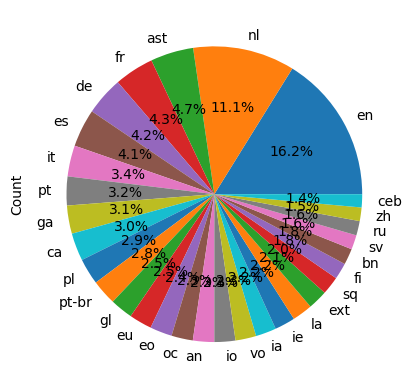

In [26]:
language_counter_df = pd.DataFrame(language_counter.most_common(30), columns=['Language', 'Count'])
language_counter_df.plot(kind='pie', y='Count', labels=language_counter_df['Language'], autopct='%1.1f%%', legend=False)

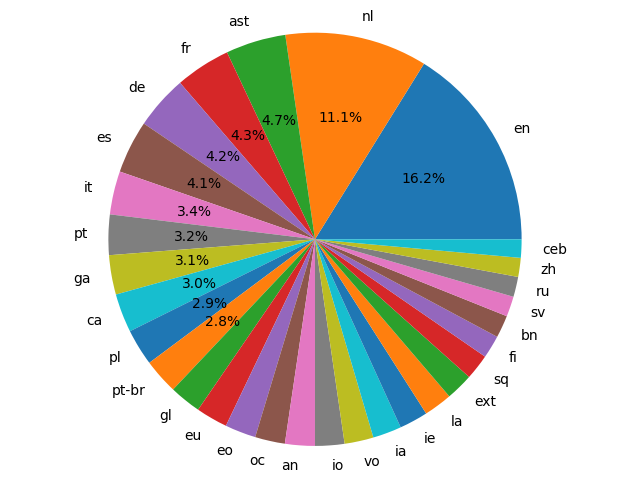

In [15]:
import matplotlib.pyplot as plt
def autopct_func(pct):
    return ('%1.1f%%' % pct) if pct >= 2.5 else ''

# plt.figure(figsize=(8, 8))

language_counter_df = pd.DataFrame(language_counter.most_common(30), columns=['Language', 'Count'])

plt.pie(language_counter_df['Count'], labels=language_counter_df['Language'], autopct=autopct_func)
plt.axis('equal')
plt.tight_layout()
plt.show()